In [1]:
from numpy import *
from numpy.linalg import *

from scipy.integrate import *
from scipy.signal import *

from matplotlib.pyplot import *

Chariot Model
==============

We consider a mobile robot of "chariot" type, evolving in the plane.

  - From above, its frame appears to be a disk of diameter $D$. 
  
  - It has two fixed wheels (their orientation with respect to the frame does not change; there is no need for a steering wheel!). They are parallel and located at opposite ends of the frame (hence separated by a distance of $D$) ; these wheels have the common radius $R$.

  - The robot is symmetric with respect to the axis that joins the two wheels. For convenience, a green sticker is attached at the boundary of the frame on one side of this axis, on the robot axis of symmetry ; this side will is called the "front" of the robot, the point itself is called the "nose" of the robot. When we talk about the "left wheel" or the "right wheel", we assume that we are looking towards the front of the robot.

We will denote 

  - $(x, y)$ the coordinates of the wheel axis in the orthonormal and direct frame $(0, e_x, e_y)$ of the plane.
  
  - $\theta$ the angle of the wheels direction with respect to vector $e_x$ ; with $\theta = 0$ when the front of the robot faces the right ($e_x$) and $\theta = \pi/2$ when he faces upwards ($e_y$).

  - $\phi_l$ and $\phi_r$ the rotation angles of the left and right wheel respectively ; by convention, when these angles increase, the robot moves forward.

### Parameter Definition


From now on, we assume that the frame diameter is $D = 1 \mbox{ m}$ and the wheel radius is $R = 10 \mbox{ cm}$.

🧩 Define the corresponding Python variables `D` and `R` (express every length in meters, and more generally in the sequel, always use the [international standard of units](https://en.wikipedia.org/wiki/SI_derived_unit)) for numerical values. 

In [2]:
D = 1
R = 10 / 100

### Graphical Representation

🧩 Implement a function `draw_robot` with arguments `x`, `y` and `theta` that draws the robot in the plane (top view) for arbitrary values of $(x, y)$ and $\theta$. Represent the robot frame as a circle, the wheels as lines and the nose as an orange point.

🗝️ **Hint.** Use the function `plot` of `matplotlib.pyplot`.

In [3]:
def draw_robot(x, y, theta):
    frame_radius = 0.5 * D
    translation = array([x, y])
    rotation = array([[cos(theta), -sin(theta)], [sin(theta), cos(theta)]])

    # Frame
    angle = linspace(0, 2*pi, 1000)
    plot(x + frame_radius * cos(angle), y + frame_radius * sin(angle), color="black")
    
    # Wheels
    wheel_left_xy_start = rotation @ [-R, frame_radius] + translation 
    wheel_left_xy_end = rotation @ [R, frame_radius] + translation
    wheel_right_xy_start = rotation @ [-R, -frame_radius] + translation
    wheel_right_xy_end = rotation @ [R, -frame_radius] + translation
    plot([wheel_left_xy_start[0], wheel_left_xy_end[0]], [wheel_left_xy_start[1], wheel_left_xy_end[1]], color="black",linewidth=5)
    plot([wheel_right_xy_start[0], wheel_right_xy_end[0]], [wheel_right_xy_start[1], wheel_right_xy_end[1]], color="black", linewidth=5)
    
    # Nose
    xn, yn = rotation @ [frame_radius, 0] + translation
    plot([xn], [yn], marker=".", color="orange", markersize=15)
    

🧩 Represent the robot in when $(x, y, \theta) = (0, 0, 0), (2, 2, \pi/2), (0, 4, -\pi), (-4, 4, -\pi), (-8, 4, -\pi)$.

🗝️ **Hint.** Use the following `draw_arena` function beforehand.

In [4]:
def draw_arena(xmin=-12, xmax=12, ymin=-9, ymax=9):
    wh_ratio = (xmax - xmin) / (ymax - ymin)
    figsize = fig_width, fig_height = 16, 16 / wh_ratio
    figure(figsize=figsize)
    axes = gca()
    axes.axis([xmin, xmax, ymin, ymax])
    axes.set_aspect(1)
    xticks(arange(xmin, xmax+1, 1))
    yticks(arange(ymin, ymax+1, 1))
    grid(True)
    plot([xmin, xmax], [0, 0], linestyle="-", color="grey")
    plot([0, 0], [ymin, ymax], linestyle="-", color="grey")

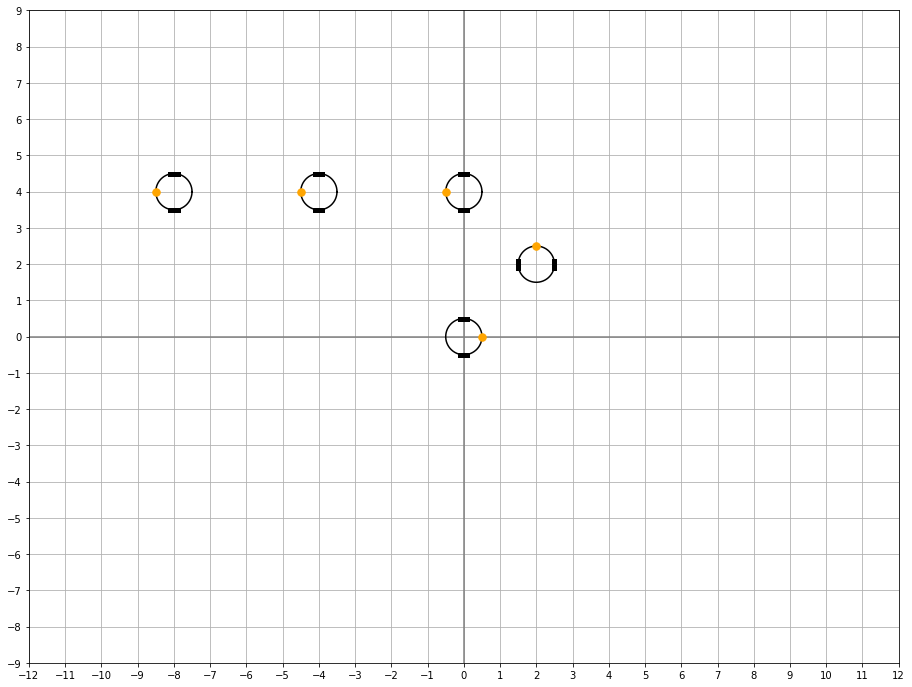

In [5]:
draw_arena()
draw_robot(0, 0, 0)
draw_robot(2, 2, pi/2)
draw_robot(0, 4, -pi)
draw_robot(-4, 4, -pi)
draw_robot(-8, 4, -pi)

### Kinematic Modeling

We assume that we can control the wheels angular velocities $\omega_l = \dot{\phi}_l$ and $\omega_r = \dot{\phi}_r$ (this is a *kinematic* model of the robot).
We also assume that the chariot wheels roll without slipping. 

🧩 Establish the differential equations that relate $\dot{x}$,
$\dot{y}$ and $\dot{\theta}$ with $\omega_l$ and $\omega_r$.

$$
\begin{array}{rcl}
\dot{x} &=& R  \frac{\omega_l + \omega_r}{2} \cos \theta \\
\dot{y} &=& R  \frac{\omega_l + \omega_r}{2} \sin \theta \\
\dot{\theta} &=& R  \frac{\omega_r - \omega_l}{D} \\
\end{array}
$$

### Analysis

🧩 Show that if $\omega_l$ and $\omega_r$ are continuously differentiable functions of $(x, y, \theta)$ (which includes the case of constant inputs), this system is well-posed.

The vector field is continuously differentiable as a composition of continuously differentiable functions, thus the IVP is well-posed.

🧩 Show that if $\omega_l$ and $\omega_r$ are constants, the maximal solution associated to any initial state is global. Is is still true of $\omega_l$ and $\omega_r$ are arbitrary continuously differentiable functions of $(x, y, \theta)$ ?

When the inputs are constant, it's pretty easy to prove that the derivatives of $x$, $y$ and $\theta$ with respect to $t$ are uniformly bounded ; thus $x$, $y$ and $\theta$ are bounded on any bounded time interval and therefore no finite-time blowup may happen: the maximal solution is global.

The situation is different with state-dependent inputs; for example with $\omega_r = - \omega_l = 0.5 D/R * \theta^2$, we end up with $\dot{\theta} = \theta(t)^2$ which has a finite-time blowup for some initial values of $\theta$. Thus, the maximal solution may not be global.

### Vector Field

In the sequel, `omega` is a function that computes the input vector $\omega := (\omega_l, \omega_r)$ given the time $t$ and $(x, y, \theta)$ (thus, it may depend on the time and/or on the system state if needed). For example:

In [6]:
def omega(t, xytheta):
    omega_l = 7.5 * pi
    omega_r = 12.5 * pi
    return array([omega_l, omega_r])

🧩 Implement a function `fun(t, xytheta)` that computes $(\dot{x}, \dot{y}, \dot{\theta})$ given the time $t$, $(x,y,\theta)$ (and  -- implicitly -- the inputs $\omega$ computed by the function `omega`).

In [7]:
def fun(t, xytheta):
    x, y, theta = xytheta
    omega_l, omega_r = omega(t, xytheta)
    dx = R * 0.5 * (omega_l + omega_r) * cos(theta)
    dy = R * 0.5 * (omega_l + omega_r) * sin(theta)
    dtheta = R * (omega_r - omega_l) / D
    return array([dx, dy, dtheta])

### Simulation Setup

🧩 Simulate the robot dynamics for 4 seconds when $(x_0, y_0, \theta_0)(t=0) = (0.0, 0.0, 0.0)$,
and the wheels velocities are the constants $\omega_l = 7.5 \pi$ and $\omega_r = 12.5 \pi$.
(Compute the dense outputs.)
   

In [8]:
r = solve_ivp(fun=fun, t_span =(0.0, 4.0), y0=[0.0, 0.0, 0.0], dense_output=True)

🧩 Use the simulation results to draw the graphs of $x(t)$, $y(t)$ and $\theta(t)$.

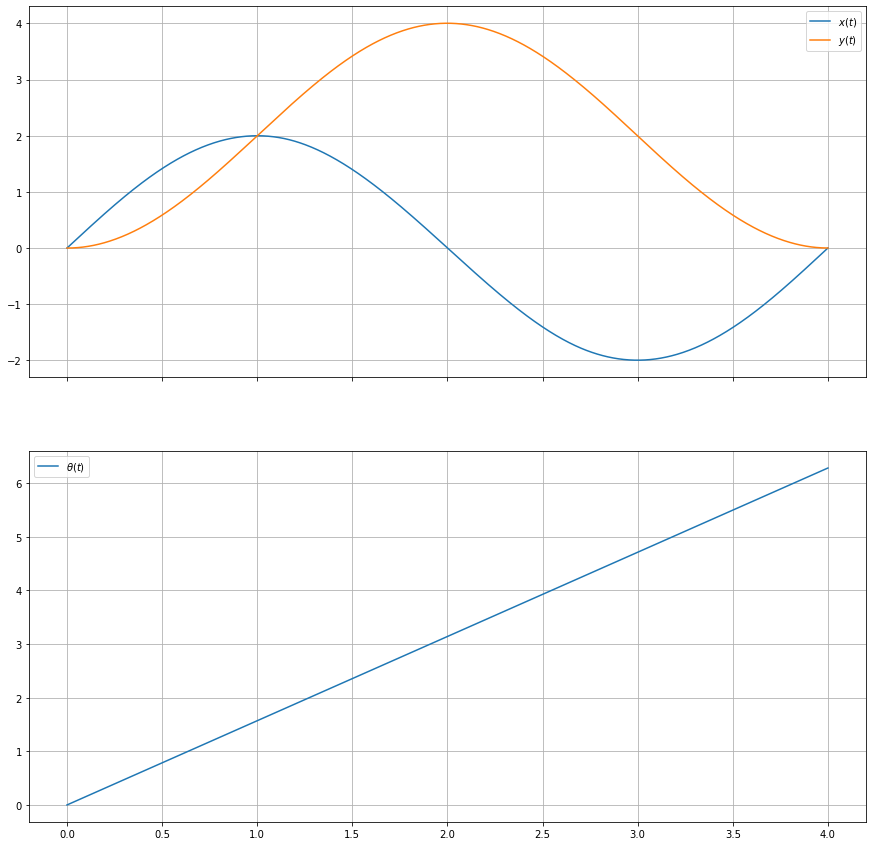

In [9]:
t = linspace(0.0, 4.0, 1000)
x, y, theta = r["sol"](t)
fig=figure(figsize=(15, 15))
ax1, ax2 = fig.subplots(2, 1, sharex=True)
ax1.grid(True)
ax1.plot(t, x, label="$x(t)$")
ax1.plot(t, y, label="$y(t)$")
ax1.legend()
ax2.grid(True)
ax2.plot(t, theta, label=r"$\theta(t)$")
ax2.legend()
pass

🧩 Use the simulation results to display the robot location every 0.5 second.

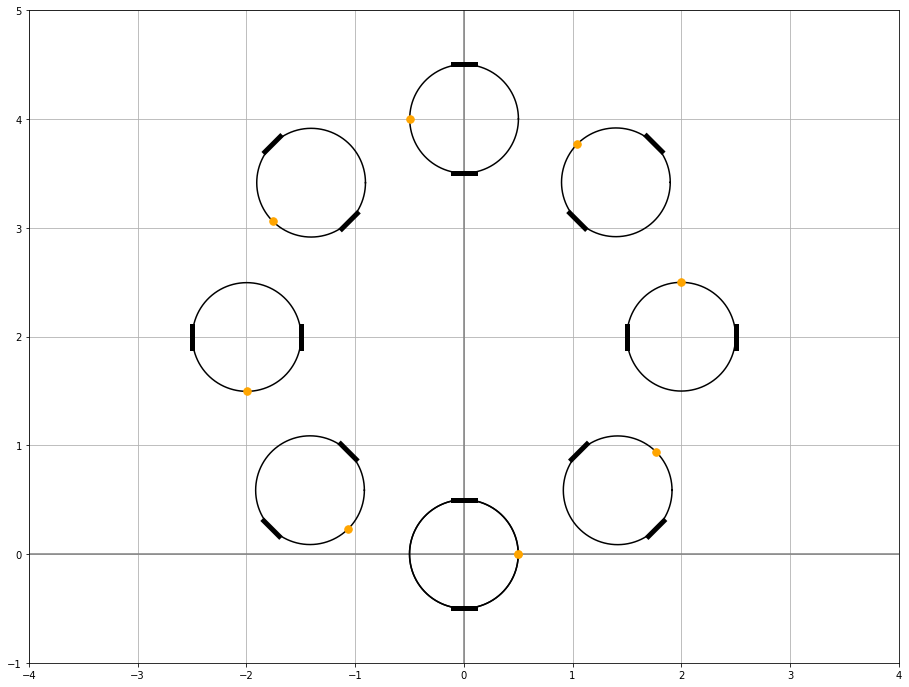

In [10]:
t = linspace(0.0, 4.0, 4*2+1)
sol_t = r["sol"](t)
draw_arena(-4, 4, -1, 5)
for x, y, theta in sol_t.T:
    draw_robot(x, y, theta)

🧩 What should be the analytical expression of $x(t)$, $y(t)$ and $\theta(t)$? 

$\theta(t) = 2 \pi / 4.0$, $x(t) = 2\sin(2\pi t / 4)$ and $y(t) = -2 \cos(2\pi t / 4)+2$.

🧩 Do you experimental results match the theoretical results ? Draw the curves of the simulation error at time $t$ for $x$, $y$ and $\theta$.

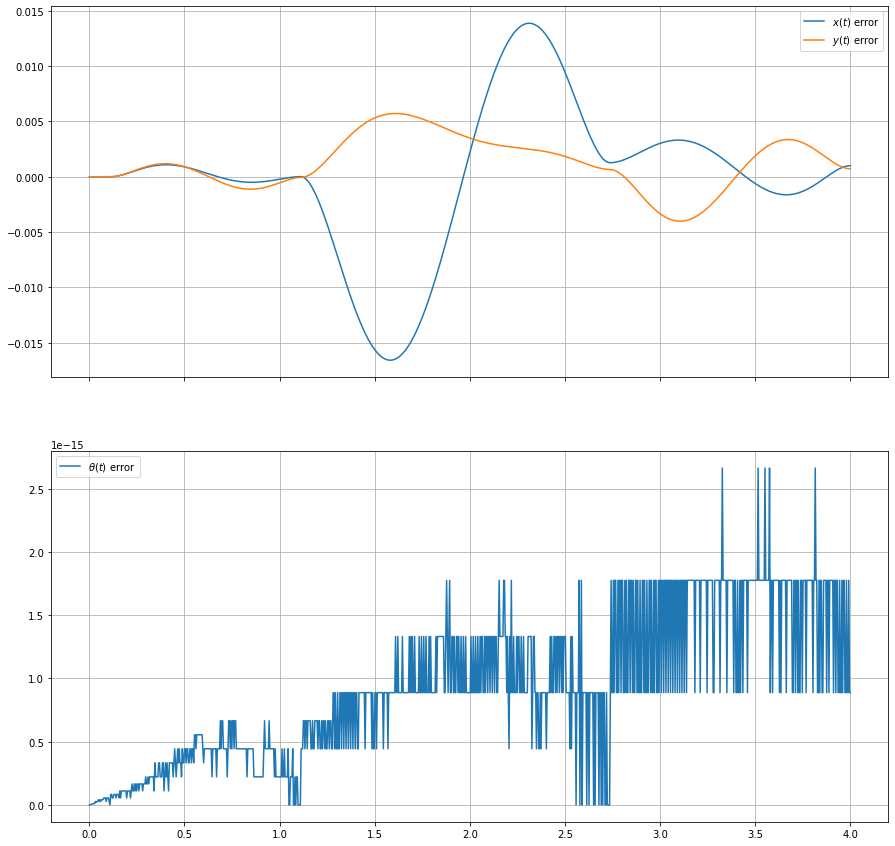

In [11]:
t = linspace(0.0, 4.0, 1000)
x_t, y_t, theta_t = r["sol"](t)
fig=figure(figsize=(15, 15))
ax1, ax2 = fig.subplots(2, 1, sharex=True)
ax1.grid(True)
ax1.plot(t , x_t - 2*sin(2*pi*t/4), label="$x(t)$ error")
ax1.plot(t , y_t + 2*cos(2*pi*t/4) - 2, label="$y(t)$ error")
ax1.legend()
ax2.grid(True)
ax2.plot(t, theta_t - 2*pi*t / 4.0, label=r"$\theta(t)$ error")
ax2.legend()
pass

🧩 If needed, adjust the simulation parameters until this error is uniformly less than $1e-5$.

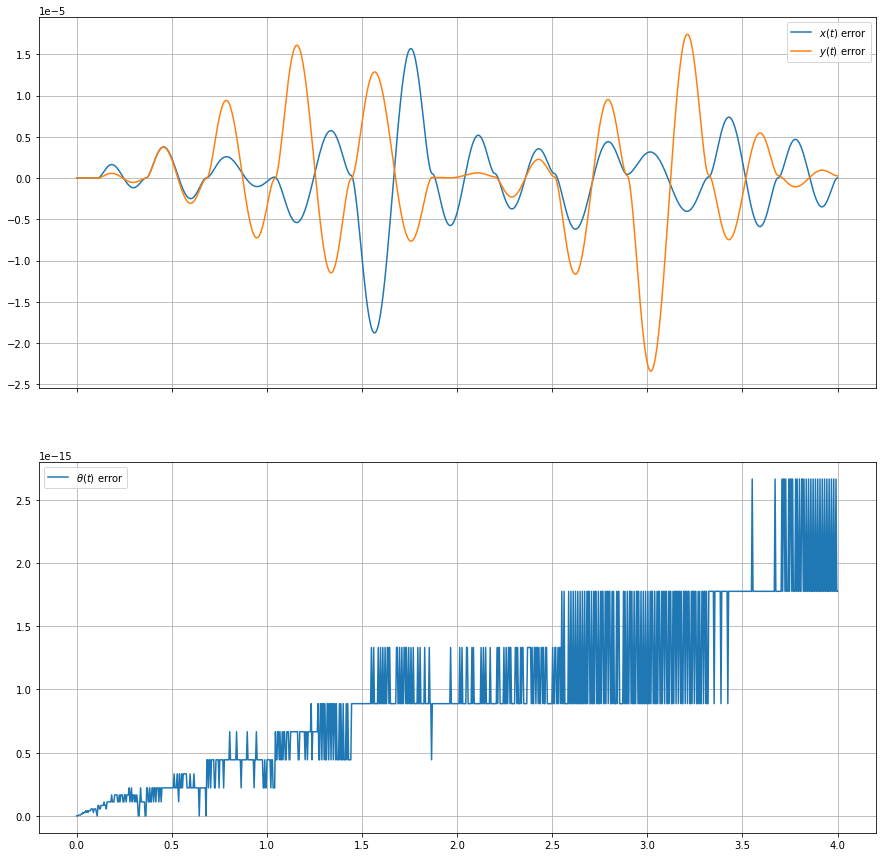

In [12]:
r = solve_ivp(fun=fun, t_span =(0.0, 4.0), y0=[0.0, 0.0, 0.0], rtol=1e-6, atol=1e-12, dense_output=True)
t = linspace(0.0, 4.0, 1000)
x_t, y_t, theta_t = r["sol"](t)
fig=figure(figsize=(15, 15))
ax1, ax2 = fig.subplots(2, 1, sharex=True)
ax1.grid(True)
ax1.plot(t , x_t - 2*sin(2*pi*t/4), label="$x(t)$ error")
ax1.plot(t , y_t + 2*cos(2*pi*t/4) - 2, label="$y(t)$ error")
ax1.legend()
ax2.grid(True)
ax2.plot(t, theta_t - 2*pi*t / 4.0, label=r"$\theta(t)$ error")
ax2.legend()
pass

Step2: implementing control
=====

Time dependent inputs
-----

We are going to simulate the case of the chariot controlled by time-dependent angular velocities $\omega_l$ and $\omega_r$. 

We want a simulation of 10s with the following inputs:
$$
    \omega_l(t) = \left\{
       \begin{array}{ll}
           2\pi & \mbox{when t $\leq$ 5s} \\
           \pi & \mbox{otherwise}
       \end{array}
    \right.
$$
and
$$
    \omega_r(t) = \left\{
       \begin{array}{ll}
           2\pi & \mbox{when t $\geq$ 5s} \\
           \pi & \mbox{otherwise}
       \end{array}
    \right.
$$

🧩 Provide the new definition of `omega`

In [29]:
def omega_l(t):
    if t<=5:
        return 2*np.pi
    else:
        return np.pi

def omega_r(t):
    if t>=5:
        return 2*np.pi
    else:
        return np.pi

def omega(t, xytheta):

    return array([omega_l(t), omega_r(t)])

🧩 Make a simulation of 10s of the robot with the previous input **without specifying** any parameter to improve the accuracy (`rtol`, `atol` and `max_step` at their default value) and by using the `dense_output` option to evaluate the solution at timesteps that will be defined later.

🗝️ **Hint.** This is not necessary to define again the function `fun`. If the previous cell has been correctly validated, `fun` will use the new definition of `omega`. 


In [30]:
r = solve_ivp(fun=fun, t_span =(0.0, 10.0), y0=[0.0, 0.0, 0.0], dense_output=True)


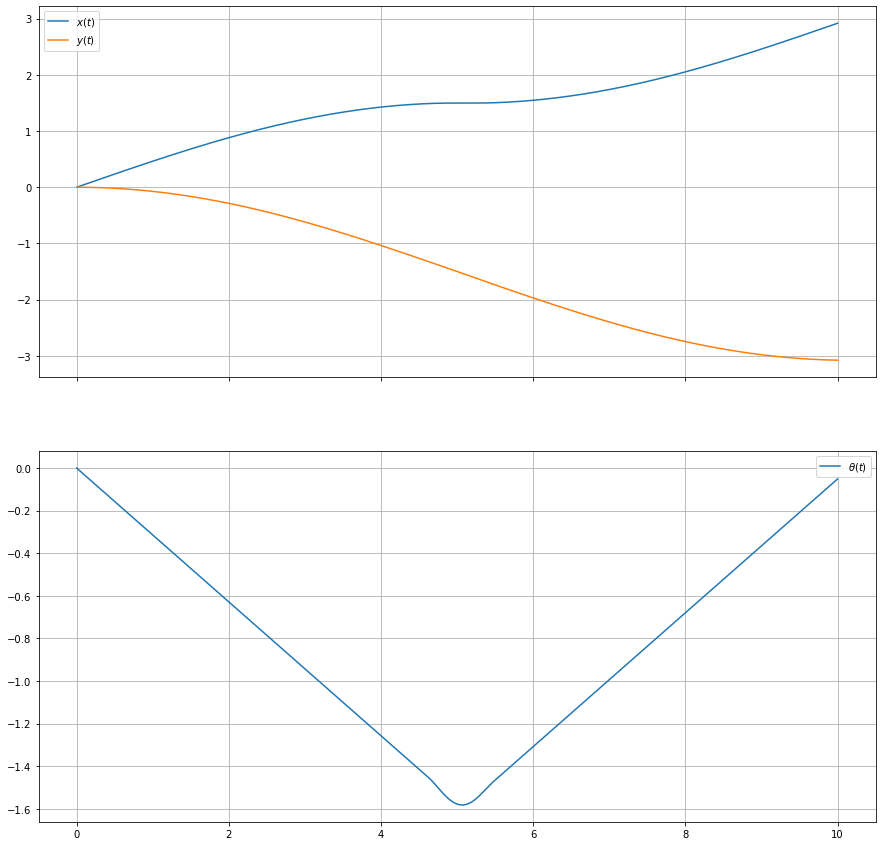

In [32]:
t = linspace(0.0, 10.0, 1000)
x, y, theta = r["sol"](t)
fig=figure(figsize=(15, 15))
ax1, ax2 = fig.subplots(2, 1, sharex=True)
ax1.grid(True)
ax1.plot(t, x, label="$x(t)$")
ax1.plot(t, y, label="$y(t)$")
ax1.legend()
ax2.grid(True)
ax2.plot(t, theta, label=r"$\theta(t)$")
ax2.legend()

🧩 Use the simulation results to display the robot location every 1.5 seconds.

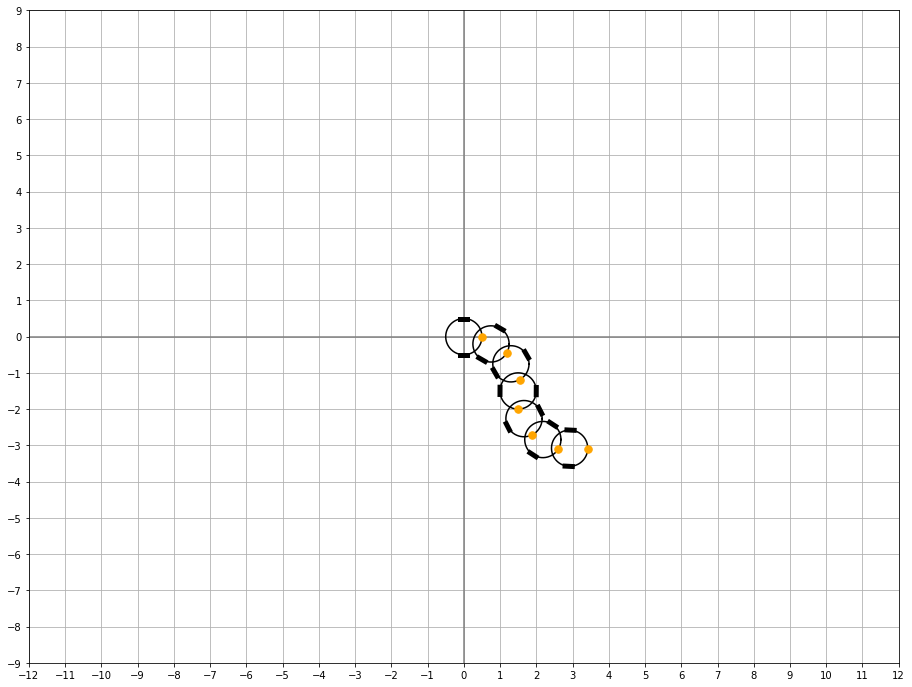

In [33]:
t = linspace(0.0, 10.0, 7)
sol_t = r["sol"](t)
draw_arena()
for x, y, theta in sol_t.T:
    draw_robot(x, y, theta)

## Analysis of the system at rest

### Equilibrium

🧩 Show that for a suitable (constant) choice $\omega_e \in \mathbb{R}^2$ of the vector input $\omega$, the state $X_e = (x_e, y_e, \theta_e) = (0,0,0)$ is an equilibrium of the mobile robot.



**Answer:**


Pour que Xe soit un point d'équilibre, il faut que f(Xe)=0
Donc: $$
\begin{array}{rcl}
\dot{x} &=& R  \frac{\omega_l + \omega_r}{2}=0\\
\dot{y} &=& R  \frac{\omega_l + \omega_r}{2}=0\\
\end{array}
$$
Alors: 
$$
\begin{array}{rcl}
\\\omega_l = \omega_r=0\\
\end{array}
$$

🧩 Show that for any other $\omega_e$, the system has no equilibrium.

**Answer:**

Afin de montrer que si $$
\begin{array}{rcl}
\\\omega_e ≠ 0\\
\end{array}
$$ le système n'admet pas de point d'équilibre, on résout:
$$
\begin{array}{rcl}
\dot{x} &=& R  \frac{\omega_l + \omega_r}{2} \cos \theta=0 \\
\dot{y} &=& R  \frac{\omega_l + \omega_r}{2} \sin \theta=0 \\
\dot{\theta} &=& R  \frac{\omega_r - \omega_l}{D} =0\\
\end{array}
$$
Il n'existe pas de θ où sin(θ)=cos(θ)=0
alors forcèment: $$
\begin{array}{rcl}
\\\omega_l = \omega_r=0\\
\end{array}
$$

🧩 Conversely, if $\omega = \omega_e$, what are the other equilibria of the system?

**Answer:**



Si $$
\begin{array}{rcl}
\\\omega_l = \omega_r=0\\
\end{array}
$$
Donc $$
\begin{array}{rcl}
\dot{x} =0 \\
\dot{y} =0 \\
\dot{\theta} =0 \\
\end{array}
$$
Alors $$
\begin{array}{rcl}
\\X_e = constante \\
\end{array}
$$
Donc l'ensemble des solutions: $$
\begin{array}{rcl}
\\X_e = (x_e, y_e, \theta_e)=R^3 \\
\end{array}
$$

### Linearized System


Let $\omega = \omega_e$ and $X_e = (0,0,0)$.

Introduce the error variables $\Delta X = (\Delta x, \Delta y, \Delta \theta) = X - X_e$.

🧩 Compute the corresponding linearized dynamics and put it in standard form: compute the matrices $A$ and $B$ (remember that $\omega = (\omega_l,\omega_r)$.

**Answer:**
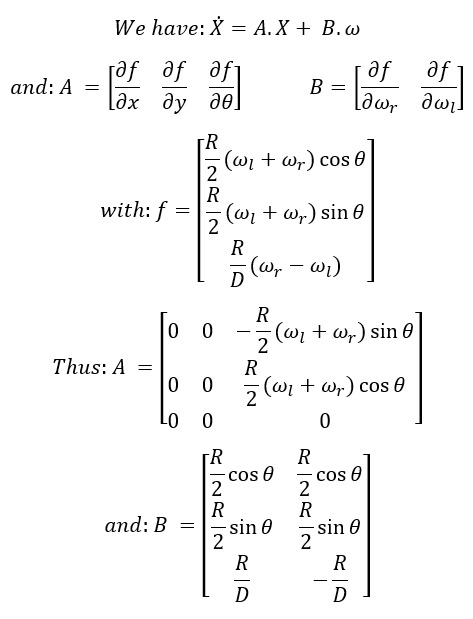


### Stability of the linearized system

🧩 Is the linearized system asymptotically stable around $(0,0,0)$ when $\Delta \omega = (0,0)$ ?

**Answer:**


🧩 Is the original system asymptotically stable ? Or even (locally) attractive ? 

**Answer:**


### Controllability of the linearized system

In this section, we consider only the linearized system defined by the matrices $A$ and $B$ computed previously:
$$
  \dot{\Delta X} = A.\Delta X + B\Delta \omega
$$

🧩 Is there an admissible trajectory that start with the state $X_0=(-2,0,0)$ and ends at origin after some time?  

**Answer:**


🧩 Is there an admissible trajectory that start with the state $X_0=(0,2,0)$ and ends at origin after some time?  

**Answer:**



🧩 Is the linearized system controllable?

**Answer:** 


## Control on a straight line

### Admissible trajectories

Let $x_R(t) = v t$ and $y_R(t) = 0$ where $v \in \mathbb{R}$ and $v \neq 0$. 

🧩 Determine the set of trajectories $X_R(t) = (x_R(t), y_R(t), \theta_R(t))$ which are admissible and compute the corresponding reference control $\omega_{R}(t)$.

**Answer:**




### Linearized system

Let $\Delta X(t) = X(t) - X_R(t)$ and $\Delta \omega(t) = \omega(t) - \omega_R(t)$.

🧩 Compute the linearized dynamics of the system for the class of trajectory "moving forward".

**Answer:**


🧩 Is the system asymptotically stable, with $\Delta\omega(t)=0$?

**Answer:**



🧩 Is the system attractive, with $\Delta\omega(t)=0$?

**Answer:**


🧩 Show that the linearized system is controllable.

**Answer:**



### Linearized system implementation

In the sequel, we will use $v=10km/h$

🧩 Implement and print the matrices $A$ and $B$

In [16]:
pass

The linear model as to be fed with some $\Delta\omega$ input. Like for the non linear system, we define a function $\Delta\omega(t,\Delta_X)$ that computes the input of the linearized system. For example, if we do not want any correction to the reference input, we will have:

In [17]:
def deltaOmega(t,deltaX):
    return array([0,0,0])

🧩 Implement a function `lin_fun(t, deltaX)` that computes $\dot{\Delta X}$ given the time $t$, $\Delta X$ (and  -- implicitly -- the inputs $\Delta\omega$ computed by the function `deltaOmega`).

In [18]:
def lin_fun(t,deltaX):
    pass

### Controller Design on the linearized system

🧩 Implement a process that computes a gain matrix $K$ that places the poles of the linearized system at some arbitrary location. For this question, we will chose 3 real poles with an absolute value close to 0.3.

Then, print the effective poles of the system: 

$$
\dot{\Delta X}= A.\Delta X + B\Delta\omega
$$
with
$$
\Delta\omega = -K.\Delta X
$$

In [19]:
pass

🧩 Simulate the linearized system during 10s, with an initial condition $\Delta X(0) = (0,2,0)$.

In [20]:
def deltaOmega(t,deltaX):
    # Make a proper new definition of deltaOmega
    pass

pass # Make the simulation

🧩 Plot the values of $\Delta x(t)$, $\Delta y(t)$ and $\Delta\theta(t)$ (**plot $\Delta\theta(t)$ in degrees**)

In [21]:
pass

🧩 Why is it important to check that $\Delta\theta(t)$ stays small ?

**Answer:**


🧩 Compute the corresponding values of $\Delta\omega_l,\Delta\omega_r$ and store them in the Python variables `dOmega_l`, `dOmega_r`

In [22]:
pass

🧩 Compute $\omega_l,\omega_r$ and plot the translation speed of each wheels in km/h

In [23]:
pass

🧩 Are the control values consistent with what the robot should do to cancel the error?

**Answer:**


###  Controller Tuning



Tune the poles so that the actual location $(x, y)$ is within 10 cm of the desired location within 5 sec (**keep continue to simulate during 10sec**) and the linear velocity of each wheel never exceeds $15$ km/h. Plot the values of $\Delta x$ (in m), $\Delta y$ (in m), $\Delta \theta$ (in degrees), and the speed of each wheel (in km/h)

🗝️ **Hint.** To answer this question, you can copy/paste the code of the previous questions to generate the appropriate plots.


In [24]:
pass


### Controller validation

The goal of this part is to test the controller on the **true** non linear system.
The idea is the following:
  - We are going to simulate the original `fun` function
  - We need to define a new version of the function `omega` that computes the wheel velocities. Basically, the following steps will be necessary:
    1. Compute $\Delta X(t)$
    1. Compute $\Delta\omega(t)$
    1. Compute $\omega(t)$ thanks to $\Delta\omega(t)$ and $\omega_R(t)$
    
🧩 Implement the new version of `omega`

In [25]:
def omega(t,xytheta):
    pass

🧩 Simulate the true system during 10sec

In [26]:
pass

🧩 Use the simulation results to display the robot location every 1 second.

In [27]:
pass

🧩 Plot the variables $x(t)$, $y(t)$, $\theta(t)$

In [28]:
pass